
# Q learning (Q-Net)

More specifically, we'll use Q-GAN to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
import numpy as np

In [2]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.8.0
Default GPU Device: /device:GPU:0


>**Note:** Make sure you have OpenAI Gym cloned. Then run this command 'pip install -e gym/[all]'.

In [3]:
import gym
# Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [4]:
env.reset()
rewards, states, actions, dones = [], [], [], []
for _ in range(10):
    #env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    states.append(state)
    rewards.append(reward)
    actions.append(action)
    dones.append(done)
    #     print('state, action, reward, done, info')
    #     print(state, action, reward, done, info)
    if done:
    #         print('state, action, reward, done, info')
    #         print(state, action, reward, done, info)
        states.append(state)
        rewards.append(reward)
        actions.append(action)
        dones.append(done)

To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [5]:
print(rewards[-20:])
print(np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print(np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print('actions:', np.max(np.array(actions)), np.min(np.array(actions)))
print('rewards min and max:', np.max(np.array(rewards)), np.min(np.array(rewards)))
print('state size:', np.array(states).shape, 
      'action size: {}'.format((np.max(np.array(actions)) - np.min(np.array(actions)))+1))

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
(10,) (10, 4) (10,) (10,)
float64 float64 int64 bool
actions: 1 0
rewards min and max: 1.0 1.0
state size: (10, 4) action size: 2


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

In [6]:
# Data of the model
def model_input(state_size):
    # Current and next states given
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    next_states = tf.placeholder(tf.float32, [None, state_size], name='next_states')
    
    # Previous and current actions given
    prev_actions = tf.placeholder(tf.int32, [None], name='prev_actions')
    actions = tf.placeholder(tf.int32, [None], name='actions')

    # Qs = qs+ (gamma * nextQs)/values/logits: using next_states and dones/end-of-episodes
    nextQs = tf.placeholder(tf.float32, [None], name='nextQs') # masked
    #nextQs_G = tf.placeholder(tf.float32, [None], name='nextQs_G') # masked
    dones = tf.placeholder(tf.bool, [None], name='dones') # masked
    nextQs_D = tf.placeholder(tf.float32, [None], name='nextQs_D') # masked
    
    # returning the given data to the model
    return states, next_states, prev_actions, actions, nextQs, dones, nextQs_D

In [7]:
# Generater: Generating/predicting action and next states
def qfunction(prev_actions, states, action_size, state_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('qfunction', reuse=reuse):
        # Fusing states and actions
        x_fused = tf.concat(axis=1, values=[prev_actions, states])
        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=x_fused, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=(action_size + state_size))
        actions_logits, next_states_logits = tf.split(axis=1, num_or_size_splits=[action_size, state_size], 
                                                      value=logits)
        #predictions = tf.nn.softmax(actions_logits)
        #predictions = tf.sigmoid(next_states_logits)

        # return actions and states logits
        return actions_logits, next_states_logits

In [8]:
def discriminator(prev_actions, states, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Fusing states and actions
        x_fused = tf.concat(axis=1, values=[prev_actions, states])
        #print(x_fused.shape)
        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=x_fused, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        #print(h1.shape)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        #print(h2.shape)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)
        #predictions = tf.nn.softmax(logits)

        # return reward logits/Qs
        return logits

In [9]:
# The original model loss
def model_loss(prev_actions, states, actions, # model input data for Qs/qs/rs 
               nextQs, gamma, # model input data for targetQs
               state_size, action_size, hidden_size): # model init for Qs
    # Calculating Qs total rewards
    prev_actions_onehot = tf.one_hot(indices=prev_actions, depth=action_size)
    actions_logits, _ = qfunction(prev_actions=prev_actions_onehot, states=states, 
                                  hidden_size=hidden_size, state_size=state_size, action_size=action_size)
    
    # Masking actions_logits unmasked
    actions_onehot = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    Qs_masked = tf.multiply(actions_logits, actions_onehot)
    Qs = tf.reduce_max(Qs_masked, axis=1)
    
    # Bellman equaion for calculating total rewards using current reward + total future rewards/nextQs
    qs = tf.sigmoid(Qs) # qt
    targetQs = qs + (gamma * nextQs)
    
    # Calculating the loss: logits/predictions vs labels
    q_loss = tf.reduce_mean(tf.square(Qs - targetQs))

    return actions_logits, q_loss

In [10]:
# The new idea of G
def model_output(actions, next_states,
                 action_size, hidden_size):
    # Discriminator for nextQs_D
    actions_onehot = tf.one_hot(indices=actions, depth=action_size)
    nextQs_D_unmasked = discriminator(prev_actions=actions_onehot, states=next_states, hidden_size=hidden_size)
    
    # Returning unmasked nextQs_D to masked using dones/ends of episodes
    return nextQs_D_unmasked

In [11]:
# The model loss for the NEW idea G & D
def model_loss2(nextQs_D, gamma, 
                prev_actions, states, 
                action_size, hidden_size):
    
    # Calculating Qs total rewards using Discriminator
    prev_actions_onehot = tf.one_hot(indices=prev_actions, depth=action_size)
    Qs = discriminator(prev_actions=prev_actions_onehot, states=states, hidden_size=hidden_size, reuse=True)
        
    # Bellman equaion: Qs = rt/qt + nextQs_G/D
    qs = tf.sigmoid(Qs) # qt
    targetQs_D = qs + (gamma * nextQs_D)
    
    # Calculating the loss: logits/predictions vs labels
    d_loss = tf.reduce_mean(tf.square(Qs - targetQs_D))

    return d_loss

In [12]:
# Calculating the loss of generator based on the generated/predicted states and actions
def model_loss3(nextQs_D, gamma,
                prev_actions, states, dones, 
                state_size, action_size, hidden_size):
    # Generator for nextQs_G
    prev_actions_onehot = tf.one_hot(indices=prev_actions, depth=action_size)
    actions_logits, next_states_logits = qfunction(prev_actions=prev_actions_onehot, states=states,
                                                   hidden_size=hidden_size, state_size=state_size, 
                                                   action_size=action_size, reuse=True)
    
    # Discriminator for nextQs_G
    nextQs_G_unmasked = discriminator(prev_actions=actions_logits, states=next_states_logits, 
                                      hidden_size=hidden_size, reuse=True)
    
    # Masking the unmasked nextQs_G using dones/end of episodes/goal
    dones_mask = tf.reshape(tensor=(1 - tf.cast(dtype=nextQs_G_unmasked.dtype, x=dones)), shape=[-1, 1])
    nextQs_G_masked = tf.multiply(nextQs_G_unmasked, dones_mask)
    nextQs_G = tf.reduce_max(axis=1, input_tensor=nextQs_G_masked)
    
    # # Bellman equaion: Qs = rt/qt + nextQs_G/D
    # qs = tf.sigmoid(Qs) # qt
    # targetQs_G = qs + (gamma * nextQs_G)
    # targetQs_D = qs + (gamma * nextQs_D)
    # targetQs_G = targetQs_D
    # nextQs_G = nextQs_D 
    
    # Calculating the loss: logits/predictions vs labels
    g_loss = tf.reduce_mean(tf.square(nextQs_G - nextQs_D))
    
    # Returning g_loss which should impact Generator
    return g_loss

In [13]:
def model_opt(q_loss, g_loss, d_loss, learning_rate):
    """
    Get optimization operations in order
    :param q_loss: Qfunction loss Tensor for action and next state prediction
    :param g_loss: Qfunction loss Tensor for action and next state prediction
    :param d_loss: Discriminator loss Tensor for reward prob/logits prediction
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    q_vars = [var for var in t_vars if var.name.startswith('qfunction')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        q_opt = tf.train.AdamOptimizer(learning_rate).minimize(q_loss, var_list=q_vars) # action prediction
        g_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=q_vars) # state prediction
        d_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars) # state & action judge

    return q_opt, g_opt, d_opt

In [14]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate, gamma):

        # Data of the Model: make the data available inside the framework
        self.states, self.next_states, self.prev_actions, self.actions, self.nextQs, self.dones, self.nextQs_D = model_input(
            state_size=state_size)

        # Loss of the Model: action prediction/generation
        self.actions_logits, self.q_loss = model_loss(
            state_size=state_size, action_size=action_size, hidden_size=hidden_size, gamma=gamma, # model init parameters
            prev_actions=self.prev_actions, states=self.states, actions=self.actions, nextQs=self.nextQs) # model input data

        # Output of the Model
        self.nextQs_D_unmasked = model_output(actions=self.actions, next_states=self.next_states,
                                              action_size=action_size, hidden_size=hidden_size)
        
        # Loss of the model: reward prob/logits prediction
        self.d_loss = model_loss2(nextQs_D=self.nextQs_D, gamma=gamma,
                                  action_size=action_size, hidden_size=hidden_size,
                                  prev_actions=self.prev_actions, states=self.states)
        
        # Loss of the model: states prediction/generation
        self.g_loss = model_loss3(nextQs_D=self.nextQs_D, gamma=gamma, dones=self.dones,
                                  state_size=state_size, action_size=action_size, hidden_size=hidden_size,
                                  prev_actions=self.prev_actions, states=self.states)
        
        # Update the model: backward pass and backprop
        self.q_opt, self.g_opt, self.d_opt = model_opt(q_loss=self.q_loss, 
                                                       g_loss=self.g_loss, 
                                                       d_loss=self.d_loss, learning_rate=learning_rate)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [15]:
from collections import deque

class Memory():    
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [16]:
print('state size:', np.array(states).shape[1], 
      'action size: {}'.format((np.max(np.array(actions)) - np.min(np.array(actions)))+1))

state size: 4 action size: 2


In [29]:
train_episodes = 1000          # max number of episodes to learn from
max_steps = 2000000000000000   # max steps in an episode
gamma = 0.99                   # future reward discount

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4                 # number of units for the input state/observation -- simulation
hidden_size = 64               # number of units in each Q-network hidden layer -- simulation
action_size = 2                # number of units for the output actions -- simulation

# Memory parameters
memory_size = 100000           # memory capacity
batch_size = 200               # experience mini-batch size
learning_rate = 0.001          # learning rate for adam

In [30]:
# Reset/init the graph/session
tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate, 
             gamma=gamma)

# Init the memory
memory = Memory(max_size=memory_size)

## Populate the experience memory

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [31]:
# Initialize the simulation
env.reset()

# Take one random step to get the pole and cart moving
prev_action = env.action_space.sample() # At-1
state, reward, done, info = env.step(prev_action) # St, Rt/Et (Epiosde)

# Make a bunch of random actions and store the experiences
for _ in range(batch_size):
    # Uncomment the line below to watch the simulation
    # env.render()

    # Make a random action
    action = env.action_space.sample()# At
    next_state, reward, done, info = env.step(action) #St+1

    # End of the episodes which defines the goal of the episode/mission
    if done is True:
        
        # Print out reward and done and check if they are the same: They are NOT.
        #print('if done is true:', reward, done)
        
        # # the episode ends so no next state
        # next_state = np.zeros(state.shape)
                
        # Add experience to memory
        memory.add((prev_action, state, action, next_state, done))
        
        # Start new episode
        env.reset()
        
        # Take one random step to get the pole and cart moving
        prev_action = env.action_space.sample()
        state, reward, done, info = env.step(prev_action)
    else:
        # Print out reward and done and check if they are the same!
        #print('else done is false:', reward, done)
        
        # Add experience to memory
        memory.add((prev_action, state, action, next_state, done))
        
        # Prepare for the next round
        prev_action = action
        state = next_state

## Training

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [32]:
# Now train with experiences
saver = tf.train.Saver()

# Total rewards and losses list for plotting
rewards_list = []
q_loss_list = []
g_loss_list = []
d_loss_list = []

# TF session for training
with tf.Session() as sess:
    
    # Initialize variables
    sess.run(tf.global_variables_initializer())

    # Restore/load the trained model 
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Training episodes/epochs
    step = 0
    for ep in range(train_episodes):
        
        # Env/agent steps/batches/minibatches
        total_reward = 0
        q_loss = 0
        g_loss = 0
        d_loss = 0
        t = 0
        while t < max_steps:
            step += 1
            
            # Uncomment this next line to watch the training
            # env.render() 
            
            # Explore or Exploit
            explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step) 
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()
            else:
                # Get action from model
                feed_dict = {model.prev_actions: np.array([prev_action]), 
                             model.states: state.reshape((1, *state.shape))}
                actions_logits = sess.run(model.actions_logits, feed_dict)
                action = np.argmax(actions_logits) # arg with max value/Q is the class of action
            
            # Take action, get new state and reward
            next_state, reward, done, info = env.step(action)
    
            # Cumulative reward
            total_reward += reward
            
            # Episode/epoch training is done/failed!
            if done is True:
                # the episode ends so no next state
                #next_state = np.zeros(state.shape)
                t = max_steps
                
                print('-------------------------------------------------------------------------------')
                print('Episode: {}'.format(ep),
                      'Total reward: {}'.format(total_reward),
                      'Training q_loss: {:.4f}'.format(q_loss),
                      'Training g_loss: {:.4f}'.format(g_loss),
                      'Training d_loss: {:.4f}'.format(d_loss),
                      'Explore P: {:.4f}'.format(explore_p))
                print('-------------------------------------------------------------------------------')
                
                # total rewards and losses for plotting
                rewards_list.append((ep, total_reward))
                q_loss_list.append((ep, q_loss))
                g_loss_list.append((ep, g_loss))
                d_loss_list.append((ep, d_loss))
                
                # Add experience to memory
                memory.add((prev_action, state, action, next_state, done))
                
                # Start new episode
                env.reset()
                
                # Take one random step to get the pole and cart moving
                prev_action = env.action_space.sample()
                state, reward, done, info = env.step(prev_action)

            else:
                # Add experience to memory
                memory.add((prev_action, state, action, next_state, done))
                
                # One step forward: At-1=At and St=St+1
                prev_action = action
                state = next_state
                t += 1
            
            # Sample mini-batch from memory
            batch = memory.sample(batch_size)
            prev_actions = np.array([each[0] for each in batch])
            states = np.array([each[1] for each in batch])
            actions = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch])
            dones = np.array([each[4] for each in batch])
            #print(prev_actions.shape, states.shape, actions.shape, next_states.shape, dones.shape, dones.dtype)
            #print(dones[:3])
            
            # Calculating nextQs and setting them to 0 for states where episode ends/fails
            feed_dict={model.prev_actions: actions, 
                       model.states: next_states}
            next_actions_logits = sess.run(model.actions_logits, feed_dict)            
            next_actions_mask = (1 - dones.astype(next_actions_logits.dtype)).reshape(-1, 1) 
            nextQs_masked = np.multiply(next_actions_logits, next_actions_mask)
            nextQs = np.max(nextQs_masked, axis=1)
            
            # Calculating nextQs for Discriminator using D(At-1, St)= Qt: NOT this one
            # Calculating nextQs for Discriminator using D(At, St+1)= Qt+1/nextQs_D/nextQs
            # Calculating nextQs for Discriminator using D(~At, ~St+1)= ~Qt+1/nextQs_G/nextQs2
            feed_dict={model.prev_actions: prev_actions, model.states: states,
                       model.actions: actions, model.next_states: next_states}
            nextQs_D_unmasked = sess.run(model.nextQs_D_unmasked, feed_dict)
            
            # Masking for the end of episodes/ goals
            dones_mask = (1 - dones.astype(nextQs_D_unmasked[0].dtype)).reshape(-1, 1)
            nextQs_D_masked = np.multiply(nextQs_D_unmasked[0], dones_mask)
            nextQs_D = np.max(nextQs_D_masked, axis=1)
            
            # Calculating nextQs for Discriminator using D(At-1, St)= Qt: NOT this one
            # D(At-1, St)= Qs and qs = tf.sigmoid(Qs)
            # NextQs/Qt+1 are given both:
            # targetQs = qs + gamma * nextQs_G
            # targetQs = qs + gamma * nextQs_D
            feed_dict = {model.prev_actions: prev_actions, 
                         model.states: states, 
                         model.actions: actions, 
                         model.next_states: next_states, 
                         model.dones: dones,
                         model.nextQs: nextQs,
                         model.nextQs_D: nextQs_D}
            q_loss, _ = sess.run([model.q_loss, model.q_opt], feed_dict)
            d_loss, _ = sess.run([model.d_loss, model.d_opt], feed_dict)
            g_loss, _ = sess.run([model.g_loss, model.g_opt], feed_dict)
            ################################################################################
            ################################################################################
                        
    # Save the trained model
    saver.save(sess, 'checkpoints/model.ckpt')

-------------------------------------------------------------------------------
Episode: 0 Total reward: 6.0 Training q_loss: 0.4341 Training g_loss: 0.0774 Training d_loss: 0.5206 Explore P: 0.9994
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1 Total reward: 36.0 Training q_loss: 0.9165 Training g_loss: 2.6567 Training d_loss: 1.1492 Explore P: 0.9959
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2 Total reward: 24.0 Training q_loss: 0.7980 Training g_loss: 0.4744 Training d_loss: 6.2689 Explore P: 0.9935
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3 Total reward: 15.0 Training q_loss: 0.7689 Training g_loss: 0.3915 Tra

-------------------------------------------------------------------------------
Episode: 31 Total reward: 24.0 Training q_loss: 0.4862 Training g_loss: 0.6172 Training d_loss: 10.7093 Explore P: 0.9336
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 32 Total reward: 25.0 Training q_loss: 0.4400 Training g_loss: 0.4556 Training d_loss: 11.6706 Explore P: 0.9313
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 33 Total reward: 18.0 Training q_loss: 0.4223 Training g_loss: 0.2460 Training d_loss: 22.4966 Explore P: 0.9297
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 34 Total reward: 17.0 Training q_loss: 0.4394 Training g_loss: 0.

-------------------------------------------------------------------------------
Episode: 61 Total reward: 15.0 Training q_loss: 0.4400 Training g_loss: 0.6219 Training d_loss: 16.3435 Explore P: 0.8843
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 62 Total reward: 16.0 Training q_loss: 0.4562 Training g_loss: 0.7987 Training d_loss: 9.0470 Explore P: 0.8829
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 63 Total reward: 13.0 Training q_loss: 0.4434 Training g_loss: 0.2421 Training d_loss: 24.3339 Explore P: 0.8818
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 64 Total reward: 29.0 Training q_loss: 0.4617 Training g_loss: 0.9

-------------------------------------------------------------------------------
Episode: 92 Total reward: 17.0 Training q_loss: 0.4197 Training g_loss: 0.3137 Training d_loss: 19.0319 Explore P: 0.8316
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 93 Total reward: 28.0 Training q_loss: 0.4121 Training g_loss: 0.6782 Training d_loss: 13.0008 Explore P: 0.8293
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 94 Total reward: 22.0 Training q_loss: 0.4347 Training g_loss: 0.1859 Training d_loss: 14.3525 Explore P: 0.8275
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 95 Total reward: 9.0 Training q_loss: 0.4366 Training g_loss: 1.7

-------------------------------------------------------------------------------
Episode: 121 Total reward: 14.0 Training q_loss: 0.4607 Training g_loss: 0.6427 Training d_loss: 17.4103 Explore P: 0.7831
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 122 Total reward: 31.0 Training q_loss: 0.4336 Training g_loss: 0.8185 Training d_loss: 11.3984 Explore P: 0.7807
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 123 Total reward: 11.0 Training q_loss: 0.4199 Training g_loss: 0.5471 Training d_loss: 15.1599 Explore P: 0.7799
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 124 Total reward: 15.0 Training q_loss: 0.4116 Training g_loss

-------------------------------------------------------------------------------
Episode: 150 Total reward: 49.0 Training q_loss: 0.4124 Training g_loss: 0.4375 Training d_loss: 19.4190 Explore P: 0.7437
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 151 Total reward: 19.0 Training q_loss: 0.4304 Training g_loss: 0.4208 Training d_loss: 17.7476 Explore P: 0.7423
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 152 Total reward: 12.0 Training q_loss: 0.4483 Training g_loss: 1.1679 Training d_loss: 14.1276 Explore P: 0.7414
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 153 Total reward: 16.0 Training q_loss: 0.4487 Training g_loss

-------------------------------------------------------------------------------
Episode: 180 Total reward: 45.0 Training q_loss: 0.5106 Training g_loss: 1.0023 Training d_loss: 8.3624 Explore P: 0.7089
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 181 Total reward: 19.0 Training q_loss: 0.4450 Training g_loss: 0.2994 Training d_loss: 16.0055 Explore P: 0.7076
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 182 Total reward: 12.0 Training q_loss: 0.4732 Training g_loss: 1.5348 Training d_loss: 10.9157 Explore P: 0.7067
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 183 Total reward: 14.0 Training q_loss: 0.4659 Training g_loss:

-------------------------------------------------------------------------------
Episode: 209 Total reward: 20.0 Training q_loss: 0.5164 Training g_loss: 1.0860 Training d_loss: 5.3335 Explore P: 0.6784
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 210 Total reward: 10.0 Training q_loss: 0.4891 Training g_loss: 1.2507 Training d_loss: 9.9157 Explore P: 0.6777
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 211 Total reward: 11.0 Training q_loss: 0.4917 Training g_loss: 0.9911 Training d_loss: 6.4807 Explore P: 0.6770
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 212 Total reward: 13.0 Training q_loss: 0.5124 Training g_loss: 0

-------------------------------------------------------------------------------
Episode: 238 Total reward: 19.0 Training q_loss: 0.5383 Training g_loss: 1.4679 Training d_loss: 13.1087 Explore P: 0.6406
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 239 Total reward: 22.0 Training q_loss: 0.4917 Training g_loss: 0.9958 Training d_loss: 12.4940 Explore P: 0.6392
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 240 Total reward: 12.0 Training q_loss: 0.4886 Training g_loss: 1.0140 Training d_loss: 12.7166 Explore P: 0.6384
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 241 Total reward: 12.0 Training q_loss: 0.5217 Training g_loss

-------------------------------------------------------------------------------
Episode: 267 Total reward: 10.0 Training q_loss: 0.5603 Training g_loss: 1.7670 Training d_loss: 8.8274 Explore P: 0.6155
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 268 Total reward: 13.0 Training q_loss: 0.6088 Training g_loss: 1.0455 Training d_loss: 9.3567 Explore P: 0.6147
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 269 Total reward: 32.0 Training q_loss: 0.5185 Training g_loss: 0.6051 Training d_loss: 12.9221 Explore P: 0.6128
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 270 Total reward: 16.0 Training q_loss: 0.5120 Training g_loss: 

-------------------------------------------------------------------------------
Episode: 296 Total reward: 23.0 Training q_loss: 0.6114 Training g_loss: 1.1733 Training d_loss: 8.7180 Explore P: 0.5826
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 297 Total reward: 15.0 Training q_loss: 0.5810 Training g_loss: 1.0219 Training d_loss: 11.2291 Explore P: 0.5818
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 298 Total reward: 12.0 Training q_loss: 0.5742 Training g_loss: 0.5646 Training d_loss: 13.9528 Explore P: 0.5811
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 299 Total reward: 11.0 Training q_loss: 0.6135 Training g_loss:

-------------------------------------------------------------------------------
Episode: 325 Total reward: 21.0 Training q_loss: 0.5469 Training g_loss: 1.8442 Training d_loss: 12.9507 Explore P: 0.5562
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 326 Total reward: 11.0 Training q_loss: 0.6818 Training g_loss: 0.9124 Training d_loss: 15.1504 Explore P: 0.5556
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 327 Total reward: 12.0 Training q_loss: 0.5886 Training g_loss: 0.9410 Training d_loss: 13.9985 Explore P: 0.5550
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 328 Total reward: 13.0 Training q_loss: 0.5494 Training g_loss

-------------------------------------------------------------------------------
Episode: 354 Total reward: 14.0 Training q_loss: 0.6161 Training g_loss: 0.3161 Training d_loss: 19.0750 Explore P: 0.5321
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 355 Total reward: 27.0 Training q_loss: 0.7167 Training g_loss: 1.2911 Training d_loss: 16.7978 Explore P: 0.5307
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 356 Total reward: 17.0 Training q_loss: 0.5489 Training g_loss: 0.9533 Training d_loss: 7.1977 Explore P: 0.5298
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 357 Total reward: 8.0 Training q_loss: 0.5457 Training g_loss: 

-------------------------------------------------------------------------------
Episode: 383 Total reward: 10.0 Training q_loss: 0.7020 Training g_loss: 1.0732 Training d_loss: 5.6301 Explore P: 0.5111
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 384 Total reward: 22.0 Training q_loss: 0.6204 Training g_loss: 0.8707 Training d_loss: 12.7493 Explore P: 0.5100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 385 Total reward: 13.0 Training q_loss: 0.6170 Training g_loss: 1.4461 Training d_loss: 5.4733 Explore P: 0.5093
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 386 Total reward: 9.0 Training q_loss: 0.6499 Training g_loss: 0

-------------------------------------------------------------------------------
Episode: 413 Total reward: 16.0 Training q_loss: 0.7029 Training g_loss: 1.2404 Training d_loss: 10.0552 Explore P: 0.4910
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 414 Total reward: 10.0 Training q_loss: 0.8213 Training g_loss: 2.1703 Training d_loss: 7.9712 Explore P: 0.4905
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 415 Total reward: 10.0 Training q_loss: 0.7361 Training g_loss: 2.1042 Training d_loss: 7.9580 Explore P: 0.4901
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 416 Total reward: 24.0 Training q_loss: 0.7455 Training g_loss: 

-------------------------------------------------------------------------------
Episode: 443 Total reward: 9.0 Training q_loss: 0.7521 Training g_loss: 2.0310 Training d_loss: 10.6769 Explore P: 0.4712
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 444 Total reward: 17.0 Training q_loss: 0.7508 Training g_loss: 1.9479 Training d_loss: 9.8596 Explore P: 0.4705
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 445 Total reward: 10.0 Training q_loss: 0.6754 Training g_loss: 1.4929 Training d_loss: 12.3143 Explore P: 0.4700
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 446 Total reward: 14.0 Training q_loss: 0.7838 Training g_loss: 

-------------------------------------------------------------------------------
Episode: 473 Total reward: 13.0 Training q_loss: 0.7594 Training g_loss: 1.6441 Training d_loss: 10.9571 Explore P: 0.4551
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 474 Total reward: 12.0 Training q_loss: 0.6558 Training g_loss: 1.0491 Training d_loss: 14.5711 Explore P: 0.4546
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 475 Total reward: 13.0 Training q_loss: 0.8429 Training g_loss: 1.7751 Training d_loss: 9.0914 Explore P: 0.4540
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 476 Total reward: 21.0 Training q_loss: 0.6482 Training g_loss:

-------------------------------------------------------------------------------
Episode: 503 Total reward: 11.0 Training q_loss: 0.8032 Training g_loss: 2.6881 Training d_loss: 7.4180 Explore P: 0.4364
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 504 Total reward: 10.0 Training q_loss: 0.8029 Training g_loss: 0.7157 Training d_loss: 11.8275 Explore P: 0.4359
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 505 Total reward: 11.0 Training q_loss: 0.7452 Training g_loss: 3.6390 Training d_loss: 11.7879 Explore P: 0.4355
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 506 Total reward: 20.0 Training q_loss: 0.7188 Training g_loss:

-------------------------------------------------------------------------------
Episode: 533 Total reward: 15.0 Training q_loss: 2.3061 Training g_loss: 0.3665 Training d_loss: 11.0501 Explore P: 0.4159
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 534 Total reward: 10.0 Training q_loss: 1.6459 Training g_loss: 0.1266 Training d_loss: 12.7561 Explore P: 0.4155
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 535 Total reward: 18.0 Training q_loss: 3.0630 Training g_loss: 0.1316 Training d_loss: 16.1452 Explore P: 0.4147
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 536 Total reward: 21.0 Training q_loss: 2.5413 Training g_loss

-------------------------------------------------------------------------------
Episode: 562 Total reward: 14.0 Training q_loss: 6.1252 Training g_loss: 0.0861 Training d_loss: 15.2150 Explore P: 0.3946
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 563 Total reward: 17.0 Training q_loss: 3.5965 Training g_loss: 0.6608 Training d_loss: 15.5617 Explore P: 0.3940
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 564 Total reward: 14.0 Training q_loss: 6.3604 Training g_loss: 0.2814 Training d_loss: 10.6517 Explore P: 0.3934
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 565 Total reward: 21.0 Training q_loss: 3.9195 Training g_loss

-------------------------------------------------------------------------------
Episode: 592 Total reward: 14.0 Training q_loss: 5.0320 Training g_loss: 0.0689 Training d_loss: 14.1569 Explore P: 0.3739
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 593 Total reward: 26.0 Training q_loss: 3.7873 Training g_loss: 0.0674 Training d_loss: 9.4970 Explore P: 0.3729
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 594 Total reward: 16.0 Training q_loss: 5.2746 Training g_loss: 0.1239 Training d_loss: 12.6750 Explore P: 0.3723
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 595 Total reward: 17.0 Training q_loss: 4.9720 Training g_loss:

-------------------------------------------------------------------------------
Episode: 622 Total reward: 15.0 Training q_loss: 4.5970 Training g_loss: 0.0832 Training d_loss: 13.3200 Explore P: 0.3559
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 623 Total reward: 23.0 Training q_loss: 2.9902 Training g_loss: 0.0571 Training d_loss: 14.0473 Explore P: 0.3551
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 624 Total reward: 15.0 Training q_loss: 3.3493 Training g_loss: 0.0451 Training d_loss: 9.9746 Explore P: 0.3546
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 625 Total reward: 17.0 Training q_loss: 3.2176 Training g_loss:

-------------------------------------------------------------------------------
Episode: 651 Total reward: 20.0 Training q_loss: 1.5159 Training g_loss: 0.0361 Training d_loss: 14.0310 Explore P: 0.3367
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 652 Total reward: 17.0 Training q_loss: 1.5234 Training g_loss: 0.1028 Training d_loss: 19.2286 Explore P: 0.3362
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 653 Total reward: 19.0 Training q_loss: 1.4334 Training g_loss: 0.0589 Training d_loss: 9.2937 Explore P: 0.3355
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 654 Total reward: 31.0 Training q_loss: 1.1386 Training g_loss:

-------------------------------------------------------------------------------
Episode: 680 Total reward: 42.0 Training q_loss: 0.9073 Training g_loss: 0.1168 Training d_loss: 5.4732 Explore P: 0.3144
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 681 Total reward: 20.0 Training q_loss: 0.7748 Training g_loss: 0.0227 Training d_loss: 11.5788 Explore P: 0.3138
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 682 Total reward: 19.0 Training q_loss: 0.7779 Training g_loss: 0.4334 Training d_loss: 12.4803 Explore P: 0.3132
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 683 Total reward: 25.0 Training q_loss: 1.0152 Training g_loss:

-------------------------------------------------------------------------------
Episode: 709 Total reward: 21.0 Training q_loss: 0.9359 Training g_loss: 0.0245 Training d_loss: 9.0608 Explore P: 0.2955
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 710 Total reward: 14.0 Training q_loss: 0.6798 Training g_loss: 0.1902 Training d_loss: 10.7812 Explore P: 0.2951
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 711 Total reward: 26.0 Training q_loss: 0.8085 Training g_loss: 0.2600 Training d_loss: 10.7681 Explore P: 0.2943
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 712 Total reward: 49.0 Training q_loss: 0.7244 Training g_loss:

-------------------------------------------------------------------------------
Episode: 738 Total reward: 19.0 Training q_loss: 0.5655 Training g_loss: 0.2684 Training d_loss: 14.9375 Explore P: 0.2660
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 739 Total reward: 37.0 Training q_loss: 0.5928 Training g_loss: 0.1490 Training d_loss: 7.2839 Explore P: 0.2651
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 740 Total reward: 37.0 Training q_loss: 0.5410 Training g_loss: 0.2913 Training d_loss: 12.8882 Explore P: 0.2641
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 741 Total reward: 27.0 Training q_loss: 0.5793 Training g_loss:

-------------------------------------------------------------------------------
Episode: 767 Total reward: 16.0 Training q_loss: 5.0458 Training g_loss: 0.2006 Training d_loss: 17.5268 Explore P: 0.2467
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 768 Total reward: 21.0 Training q_loss: 4.1794 Training g_loss: 0.0440 Training d_loss: 13.3458 Explore P: 0.2462
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 769 Total reward: 16.0 Training q_loss: 2.2128 Training g_loss: 2.3809 Training d_loss: 14.1413 Explore P: 0.2458
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 770 Total reward: 15.0 Training q_loss: 2.3716 Training g_loss

-------------------------------------------------------------------------------
Episode: 796 Total reward: 14.0 Training q_loss: 1.3038 Training g_loss: 0.1001 Training d_loss: 7.5727 Explore P: 0.2315
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 797 Total reward: 46.0 Training q_loss: 1.5300 Training g_loss: 1.4308 Training d_loss: 21.4358 Explore P: 0.2305
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 798 Total reward: 19.0 Training q_loss: 1.3522 Training g_loss: 0.2084 Training d_loss: 7.7749 Explore P: 0.2301
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 799 Total reward: 17.0 Training q_loss: 1.3843 Training g_loss: 

-------------------------------------------------------------------------------
Episode: 825 Total reward: 41.0 Training q_loss: 0.7136 Training g_loss: 0.0866 Training d_loss: 5.3622 Explore P: 0.2144
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 826 Total reward: 18.0 Training q_loss: 0.6455 Training g_loss: 2.8044 Training d_loss: 13.0387 Explore P: 0.2140
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 827 Total reward: 24.0 Training q_loss: 0.7320 Training g_loss: 0.3117 Training d_loss: 17.6908 Explore P: 0.2135
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 828 Total reward: 16.0 Training q_loss: 1.1389 Training g_loss:

-------------------------------------------------------------------------------
Episode: 854 Total reward: 14.0 Training q_loss: 59.0592 Training g_loss: 6.3633 Training d_loss: 15.0397 Explore P: 0.1975
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 855 Total reward: 10.0 Training q_loss: 25.1132 Training g_loss: 44.5870 Training d_loss: 19.0315 Explore P: 0.1973
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 856 Total reward: 11.0 Training q_loss: 6.0460 Training g_loss: 38.1448 Training d_loss: 10.7888 Explore P: 0.1971
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 857 Total reward: 47.0 Training q_loss: 7.4357 Training g_

-------------------------------------------------------------------------------
Episode: 883 Total reward: 31.0 Training q_loss: 5.8202 Training g_loss: 18.3848 Training d_loss: 17.3997 Explore P: 0.1849
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 884 Total reward: 33.0 Training q_loss: 8.3148 Training g_loss: 4.4609 Training d_loss: 14.4903 Explore P: 0.1843
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 885 Total reward: 28.0 Training q_loss: 6.9656 Training g_loss: 0.3409 Training d_loss: 11.8418 Explore P: 0.1838
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 886 Total reward: 23.0 Training q_loss: 7.0922 Training g_los

-------------------------------------------------------------------------------
Episode: 912 Total reward: 21.0 Training q_loss: 3.2912 Training g_loss: 2.4966 Training d_loss: 11.3808 Explore P: 0.1739
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 913 Total reward: 10.0 Training q_loss: 2.9582 Training g_loss: 4.4813 Training d_loss: 8.4638 Explore P: 0.1737
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 914 Total reward: 12.0 Training q_loss: 2.9728 Training g_loss: 0.4805 Training d_loss: 18.7916 Explore P: 0.1735
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 915 Total reward: 14.0 Training q_loss: 2.9492 Training g_loss:

-------------------------------------------------------------------------------
Episode: 942 Total reward: 21.0 Training q_loss: 2.0942 Training g_loss: 1.9666 Training d_loss: 21.0086 Explore P: 0.1664
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 943 Total reward: 15.0 Training q_loss: 2.2944 Training g_loss: 3.5104 Training d_loss: 15.5176 Explore P: 0.1661
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 944 Total reward: 16.0 Training q_loss: 2.4577 Training g_loss: 0.9471 Training d_loss: 15.9797 Explore P: 0.1659
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 945 Total reward: 16.0 Training q_loss: 2.9445 Training g_loss

-------------------------------------------------------------------------------
Episode: 971 Total reward: 24.0 Training q_loss: 2.7502 Training g_loss: 4.8078 Training d_loss: 15.5205 Explore P: 0.1601
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 972 Total reward: 36.0 Training q_loss: 2.4361 Training g_loss: 0.2423 Training d_loss: 13.2272 Explore P: 0.1596
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 973 Total reward: 23.0 Training q_loss: 3.4614 Training g_loss: 1.5207 Training d_loss: 11.1518 Explore P: 0.1592
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 974 Total reward: 21.0 Training q_loss: 3.5331 Training g_loss

## Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [38]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N

Text(0,0.5,'Total rewards')

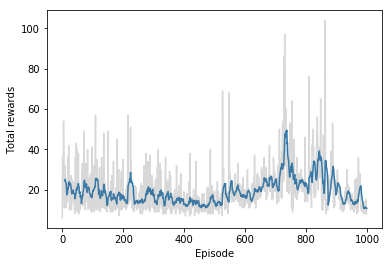

In [39]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Q losses')

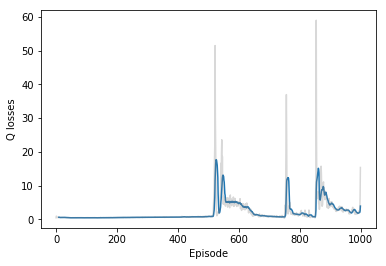

In [40]:
eps, arr = np.array(q_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Q losses')

Text(0,0.5,'G losses')

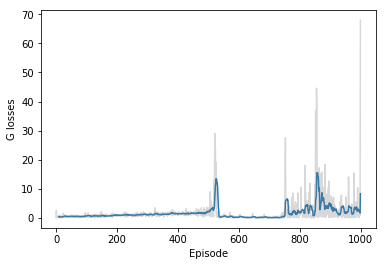

In [41]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'D losses')

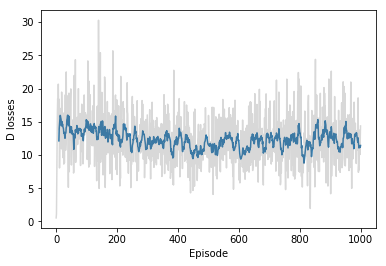

In [43]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [34]:
test_episodes = 1
test_max_steps = 20000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000

# # # Create the env after closing it.
# env = gym.make('CartPole-v0')
# # env = gym.make('Acrobot-v1')
env.reset()

with tf.Session() as sess:
    
    # Restore/load the trained model 
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # iterations
    for ep in range(test_episodes):
        
        # number of env/rob steps
        t = 0
        while t < test_max_steps:
            
            # Rendering the env graphics
            env.render()
            
            # Get action from the model
            feed_dict = {model.prev_actions: np.array([prev_action]), 
                         model.states: state.reshape((1, *state.shape))}
            actions_logits = sess.run(model.actions_logits, feed_dict)
            action = np.argmax(actions_logits)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
            
            # The task is done or not;
            if done:
                t = test_max_steps
                env.reset()
                
                # Take one random step to get the pole and cart moving
                prev_action = env.action_space.sample()
                state, reward, done, _ = env.step(prev_action)
            else:
                state = next_state
                t += 1

INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


In [35]:
# # Closing the env
# # WARNING: If you close, you can NOT restart again!!!!!!
# env.close()

## Extending this to Deep Convolutional QAN

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.